In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

from tennessee_eastman import get_faulty_by_id, get_faulties
from shap_contribution import get_shap_contribution, plot_variable
from pca_contribution import get_pca_contribution, t2s, t2t
from sklearn.metrics import accuracy_score

In [41]:
X_train, y_train, X_test, y_test = get_faulty_by_id(1)

# Contribuições
### Contribuição PCA

In [42]:
M = t2t(X_test[0:99, :])
Y = t2s(X_test[100:200, :], M);

contributions = get_pca_contribution(X_test[155:165, :], M)

print(contributions)

      values  variables
1   3.877826        1.0
2   2.599067        2.0
12  0.955277       12.0
15  0.918968       15.0
6   0.514114        6.0
43  0.166226       43.0
19  0.132309       19.0
18  0.103018       18.0
44  0.058998       44.0
47  0.051352       47.0
13  0.050148       13.0
41  0.048562       41.0
14  0.048153       14.0
39  0.047459       39.0
46  0.041095       46.0
11  0.031867       11.0
7   0.031574        7.0
16  0.030404       16.0
30  0.026835       30.0
45  0.026477       45.0
40  0.024143       40.0
42  0.023276       42.0
48  0.022089       48.0
32  0.021386       32.0
22  0.018936       22.0
20  0.014741       20.0
24  0.013431       24.0
21  0.011341       21.0
29  0.009618       29.0
10  0.008780       10.0
17  0.008483       17.0
28  0.007981       28.0
4   0.007137        4.0
31  0.006640       31.0
5   0.006494        5.0
25  0.005853       25.0
51  0.005380       51.0
23  0.004959       23.0
49  0.004839       49.0
3   0.002784        3.0
26  0.002513    

### Contribuição SHAP

In [43]:
model = RandomForestClassifier(random_state=1234)

contributions = get_shap_contribution(model, X_train[460:], y_train[460:], X_test)

print(contributions)

          feature_importance_vals
col_name                         
43                      35.012845
3                       30.927759
0                       25.148846
17                      21.317905
49                      17.734125
18                      14.932494
6                        9.803227
37                       6.590707
12                       6.430250
44                       4.985397
38                       4.568779
15                       3.843653
27                       3.340540
32                       2.558051
33                       2.541114
19                       2.379990
30                       1.943516
40                       1.865164
10                       1.708714
24                       1.291807
5                        1.068831
46                       1.043662
39                       0.944045
28                       0.932695
9                        0.881644
20                       0.817154
2                        0.775495
7             

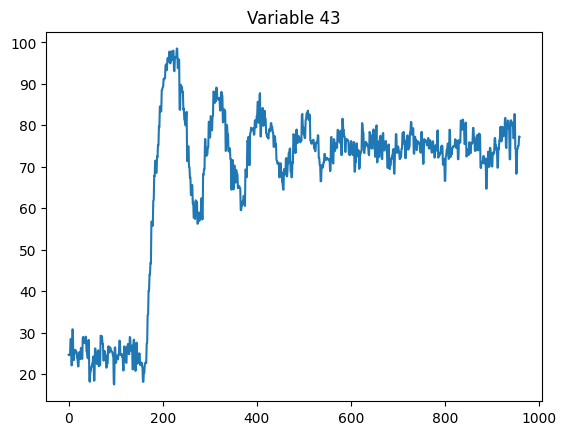

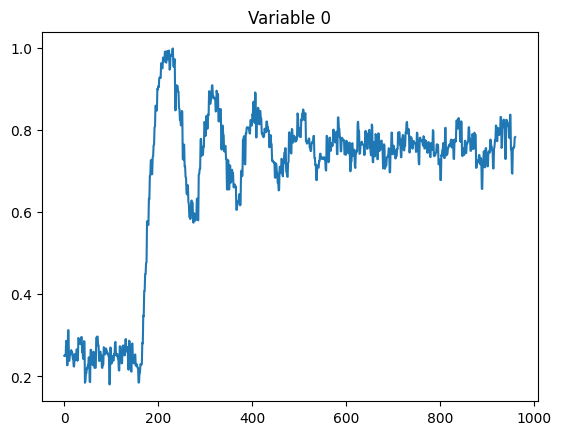

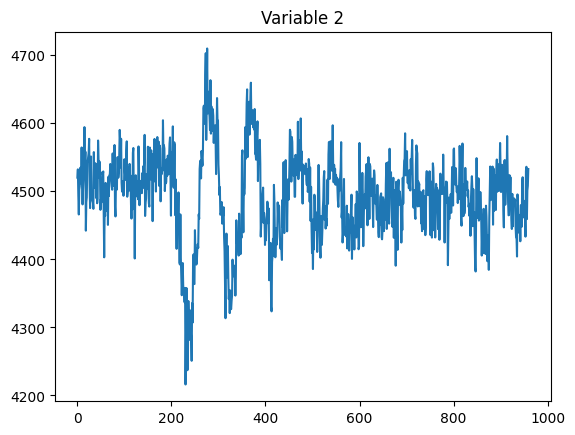

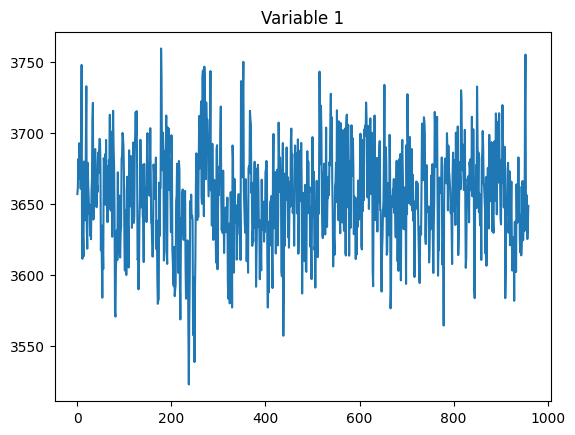

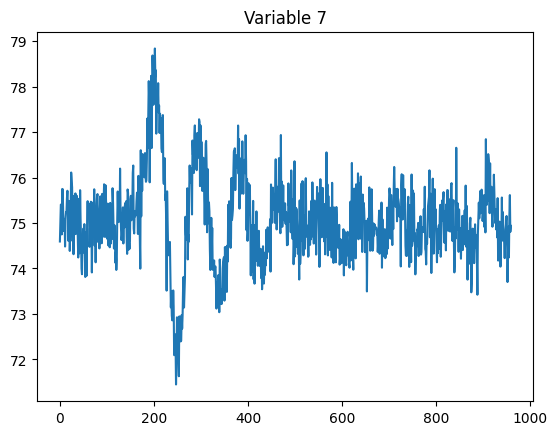

In [44]:
plot_variable(X_test, 43)
plot_variable(X_test, 0)

plot_variable(X_test, 2)
plot_variable(X_test, 1)
plot_variable(X_test, 7)

### Provando que o SHAP seleciona variaveis compativeis na identificação

In [45]:
model = RandomForestClassifier(random_state=1234)

print(X_train.shape)
print(y_train.shape)

# Fitting model
model.fit(X_train, y_train)
# Predicting with the trained model
predicted = model.predict(X_test)

print('Accuracy with all variables: ', accuracy_score(y_test, predicted))

# Apenas com as duas primeiras variaveis

model = RandomForestClassifier(random_state=1234)

# Setting up a new dataset with the first 2 most important variables
X_temporary = np.vstack([X_train[:, contributions.index[0]], X_train[:, contributions.index[1]]]).T
X_test_temporary = np.vstack([X_test[:, contributions.index[0]], X_test[:, contributions.index[1]]]).T

# Fitting model
model.fit(X_temporary, y_train)
# Predicting with the first 2 most important variables
predicted = model.predict(X_test_temporary)

print('Accuracy with the first 2 most important variables: ', accuracy_score(y_test, predicted))

(980, 52)
(980,)
Accuracy with all variables:  0.9979166666666667
Accuracy with the first 2 most important variables:  0.990625


### Verificando se o SHAP conseguira separar váriaveis para cada falha contra as demais

In [46]:
all_contributions = pd.DataFrame(columns=['index', 'value'])
all_accuracies = pd.DataFrame(columns=['index', 'value'])

for i in range(1, 22):
    # Setting up the dataset with all falties with binary distribution
    X_train, y_train, X_test, y_test = get_faulties(i)

    print(np.array(np.where(y_train == 1)).shape)
    print(np.array(np.where(y_train == 0)).shape)

    model = RandomForestClassifier(random_state=1234)

    # Calculating the variables contributions
    contributions = get_shap_contribution(model, X_train, y_train, X_test)

    model = RandomForestClassifier(random_state=1234)

    # Setting up a new dataset with the first 2 most important variables
    X_temporary = np.vstack([X_train[:, contributions.index[0]], X_train[:, contributions.index[1]]]).T
    X_test_temporary = np.vstack([X_test[:, contributions.index[0]], X_test[:, contributions.index[1]]]).T

    model.fit(X_temporary, y_train)
    predicted = model.predict(X_test_temporary)

    # Calculating accuracy of these two variables
    accuracy = accuracy_score(y_test, predicted)
    print('Accuracy with the first 2 most important variables: ', accuracy)

    # Adding this accuracy to the dataframe
    all_accuracies = all_accuracies.append({'index': i - 1, 'value': accuracy}, ignore_index=True)

    print('Falha', i)
    print(contributions)

    # Adding this contribution to the dataframe
    all_contributions = all_contributions.append({'index': i - 1, 'value': contributions.index}, ignore_index=True)

(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9920454545454546
Falha 1
          feature_importance_vals
col_name                         
0                      205.945740
43                     157.417590
3                      116.315802
49                      92.976025
18                      71.297740
17                      70.316793
44                      32.308043
33                      20.773625
9                       13.043490
37                      10.404561
19                       9.757536
46                       6.030137
28                       5.434502
6                        5.415268
27                       5.009062
22                       4.642360
24                       4.376940
15                       4.117286
12                       3.627254
32                       3.541298
30                       2.979295
7                        2.947733
40                       2.877153
10             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9926136363636363
Falha 2
          feature_importance_vals
col_name                         
9                      182.078466
46                     129.971694
33                     109.120257
27                      95.121656
18                      53.101379
49                      50.252586
2                       33.311131
21                      32.623394
3                       29.105443
29                      26.376325
42                      18.839488
23                      18.341433
38                      17.657019
17                      15.495594
6                        7.068656
10                       6.941015
34                       6.485883
5                        6.103168
12                       5.236133
15                       3.989803
19                       3.948694
36                       2.618338
45                       2.159141
35             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.6454545454545455
Falha 3
          feature_importance_vals
col_name                         
49                      85.890745
37                      68.638303
18                      60.164429
17                      30.750661
38                      29.634886
19                      28.171979
36                      27.710703
20                      22.133326
6                       22.054933
40                      21.215007
12                      21.065602
39                      18.658518
15                      14.493170
42                       9.456655
45                       9.106540
25                       8.732078
24                       8.468009
34                       8.382251
23                       8.186123
30                       7.955033
35                       7.667036
41                       7.417950
32                       7.163637
26             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9982954545454545
Falha 4
          feature_importance_vals
col_name                         
50                     584.012698
17                      39.142102
19                      18.567302
38                      18.338182
33                      15.621587
45                      14.877646
18                      13.200318
36                      12.781672
39                      12.636975
20                       9.981299
12                       9.528777
49                       8.783966
37                       7.959263
6                        7.580744
28                       7.135604
9                        7.088145
40                       6.833260
8                        5.715244
24                       5.122673
15                       4.780019
27                       4.520779
43                       4.098151
46                       3.952408
22             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.990909090909091
Falha 5
          feature_importance_vals
col_name                         
51                     301.874382
16                      83.398737
49                      54.701650
37                      49.578545
18                      47.810611
17                      34.961017
36                      18.181899
15                      15.812422
38                      14.375027
24                      14.310978
32                      14.036052
12                      12.902735
10                      12.855737
6                       11.837222
28                       8.895754
39                       8.769255
30                       8.443966
2                        8.079603
40                       7.473525
34                       7.358855
27                       7.179427
43                       7.012970
26                       6.732895
19              

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  1.0
Falha 6
          feature_importance_vals
col_name                         
0                      151.139043
43                     126.076511
19                      87.786805
22                      83.006995
30                      67.257877
45                      60.570066
24                      42.317044
28                      40.969602
15                      30.092389
49                      27.532434
35                      20.251220
33                      19.561477
34                      18.815133
18                      15.783932
3                       11.428653
20                       9.516149
6                        8.552055
21                       6.226017
46                       5.910341
37                       5.117804
12                       4.984460
42                       3.691415
27                       3.477284
9                        3.359

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  1.0
Falha 7
          feature_importance_vals
col_name                         
44                     489.570312
37                      69.616823
49                      66.047244
18                      43.874266
17                      36.056723
32                      19.812398
19                      17.572081
28                      13.419150
26                      10.026376
6                        8.918044
45                       8.425008
2                        7.855516
12                       7.063244
7                        5.808547
3                        5.542623
0                        5.529727
43                       4.683237
24                       4.479800
42                       3.948276
30                       3.610360
38                       3.502056
15                       3.442955
22                       3.369990
39                       3.334

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.8960227272727272
Falha 8
          feature_importance_vals
col_name                         
28                      70.780073
49                      67.441068
22                      56.598708
37                      55.455704
18                      51.923870
0                       43.401791
43                      41.370932
46                      36.198348
19                      34.567925
33                      33.929575
9                       33.886789
27                      29.959488
30                      26.415317
17                      21.881751
32                      19.643272
24                      19.352873
45                      17.787763
6                       13.181514
15                       9.259362
38                       8.674983
7                        8.522993
3                        8.504755
12                       8.230253
26             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.6511363636363636
Falha 9
          feature_importance_vals
col_name                         
49                      89.099552
18                      69.154954
37                      66.585190
17                      58.984561
40                      46.616163
19                      29.209914
6                       23.756018
36                      19.482521
30                      17.672872
15                      17.265236
12                      15.804037
45                      15.648867
38                      15.307099
28                      15.204872
43                      10.650209
24                      10.161807
34                       9.864448
32                       9.469249
39                       9.454730
2                        8.344988
35                       8.244726
33                       7.789373
22                       7.476286
10             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.7534090909090909
Falha 10
          feature_importance_vals
col_name                         
18                     149.170009
49                     115.893196
17                     114.951290
37                      91.627197
30                      22.684948
6                       21.026299
19                      19.461159
12                      18.736866
15                      16.278963
39                      12.053266
10                      10.881595
33                      10.276223
24                       9.533217
28                       9.144376
38                       7.576116
0                        7.313603
32                       7.088691
36                       7.009698
43                       6.812714
45                       5.836623
27                       5.645173
34                       5.562506
20                       4.862895
9             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.875
Falha 11
          feature_importance_vals
col_name                         
50                     232.371063
8                      151.638703
37                      49.756581
36                      23.761321
49                      22.827343
12                      21.478138
39                      18.653012
19                      18.402834
18                      16.492207
6                       16.170763
40                      12.844875
17                      10.588929
15                      10.464788
38                      10.114263
10                       8.547002
20                       7.613608
33                       7.047889
30                       6.831203
35                       6.056571
34                       5.867552
45                       5.759721
25                       5.640316
2                        5.494401
43                       5.

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.8596590909090909
Falha 12
          feature_importance_vals
col_name                         
49                     106.083218
18                      89.966133
17                      77.251534
37                      69.416687
32                      45.111367
21                      43.926535
28                      28.784082
19                      28.485015
10                      28.394670
3                       28.097015
45                      24.854872
34                      24.756494
2                       17.572995
26                      16.074905
7                       15.774410
15                      14.808511
43                      13.686386
30                      13.518157
42                      13.262895
6                       13.022906
36                      10.127078
12                       9.914721
0                        8.321814
44            

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9164772727272728
Falha 13
          feature_importance_vals
col_name                         
18                     141.870357
49                     140.986077
17                     132.404117
37                      53.533786
34                      30.288832
10                      28.141127
45                      26.691212
2                       23.705076
32                      20.612335
33                      20.458666
6                       19.914087
42                      18.025304
15                      13.551934
12                      11.602309
27                      10.604127
20                       9.297856
26                       7.977230
46                       7.649425
1                        7.281840
39                       7.154739
38                       7.151470
19                       6.914658
31                       6.459667
35            

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9994318181818181
Falha 14
          feature_importance_vals
col_name                         
8                      261.099874
20                     230.519390
50                     187.189280
18                      16.369979
17                      15.115816
37                      14.293604
49                      12.816570
39                      10.552822
19                       9.758167
15                       8.965912
27                       8.526687
36                       7.216998
38                       6.502367
40                       4.779747
12                       4.664453
43                       3.854813
30                       3.689728
34                       3.673524
26                       3.584305
24                       3.455206
45                       3.433057
22                       3.246524
25                       3.190112
6             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.5886363636363636
Falha 15
          feature_importance_vals
col_name                         
17                      75.755748
18                      62.365168
49                      61.114827
19                      27.920033
39                      25.919084
37                      23.967723
38                      22.728787
36                      22.607001
28                      20.676162
26                      15.848864
12                      15.655725
33                      15.574141
40                      13.544085
15                      12.792362
6                       11.818393
24                      11.604709
30                      11.544787
34                      10.293925
32                      10.024255
45                       9.992509
50                       9.253639
9                        8.809236
20                       8.513599
10            

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.8397727272727272
Falha 16
          feature_importance_vals
col_name                         
49                     222.758691
18                     138.246525
17                      56.714430
37                      47.688278
19                      43.660774
39                      20.592120
6                       13.210745
36                      13.170817
38                      12.222961
12                      12.071819
15                      11.552869
34                      11.021251
45                      10.965043
28                       8.342818
27                       7.405592
30                       7.285630
43                       7.150824
32                       6.890965
31                       6.565812
40                       5.966153
26                       5.927471
23                       5.910682
10                       5.881460
24            

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9590909090909091
Falha 17
          feature_importance_vals
col_name                         
20                     371.583809
8                       92.708371
50                      69.630178
18                      44.770848
37                      43.841606
49                      41.363163
19                      16.853470
39                      13.082383
10                      12.501896
17                      12.060230
6                       10.548355
34                       8.745849
40                       8.254419
12                       7.135908
15                       6.677861
36                       6.294150
38                       5.529172
2                        5.379650
45                       4.438410
41                       4.297709
21                       4.035881
24                       3.864029
35                       3.447912
7             

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9375
Falha 18
          feature_importance_vals
col_name                         
21                     120.632296
3                       65.779299
49                      65.424542
28                      56.903701
19                      54.157028
22                      53.762911
18                      48.442423
32                      47.564365
17                      44.548373
37                      26.145438
42                      26.135179
43                      24.954138
26                      24.456803
5                       21.573364
2                       20.029597
10                      15.575944
34                      13.816424
38                      11.771864
40                       9.464578
15                       7.973492
12                       7.237388
7                        7.064882
35                       6.788320
6                        6

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.8079545454545455
Falha 19
          feature_importance_vals
col_name                         
4                      200.916783
45                     102.767301
37                      41.521094
49                      39.335324
18                      37.732831
36                      29.769410
19                      22.970028
17                      14.437169
12                      13.866147
40                      12.846224
39                      12.636647
6                       12.525040
15                      12.133343
26                       9.835023
38                       9.341051
28                       9.124234
31                       8.526904
50                       7.495961
34                       7.408461
29                       7.339248
46                       7.323508
5                        7.317844
24                       6.265521
33            

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.7960227272727273
Falha 20
          feature_importance_vals
col_name                         
45                     171.035361
12                     137.624284
19                     104.525947
37                      33.530833
10                      29.580684
18                      25.999037
49                      22.321188
21                      16.046008
6                       13.977803
15                      13.403674
28                      13.349809
39                      11.753874
17                      11.643663
32                      11.609176
36                      11.136798
40                      10.611729
38                      10.491255
22                      10.266248
26                       9.990061
41                       9.958484
43                       9.430558
30                       9.333741
20                       8.401025
34            

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


(1, 480)
(1, 1300)
(1780, 2)
(1780,)
(1760, 2)
(1760,)
Accuracy with the first 2 most important variables:  0.9982954545454545
Falha 21
          feature_importance_vals
col_name                         
44                     221.803165
18                      61.186204
6                       53.900078
15                      46.226618
49                      45.185942
12                      40.295142
34                      31.554815
10                      30.711388
17                      27.020935
36                      19.325926
7                       16.827591
45                      15.694908
3                       13.938503
19                      11.717741
39                       9.446970
21                       8.222908
20                       6.384009
30                       5.772224
38                       5.599331
43                       5.180081
40                       5.132678
37                       4.984297
26                       4.778169
42            

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [47]:
print(all_accuracies)

    index     value
0     0.0  0.992045
1     1.0  0.992614
2     2.0  0.645455
3     3.0  0.998295
4     4.0  0.990909
5     5.0  1.000000
6     6.0  1.000000
7     7.0  0.896023
8     8.0  0.651136
9     9.0  0.753409
10   10.0  0.875000
11   11.0  0.859659
12   12.0  0.916477
13   13.0  0.999432
14   14.0  0.588636
15   15.0  0.839773
16   16.0  0.959091
17   17.0  0.937500
18   18.0  0.807955
19   19.0  0.796023
20   20.0  0.998295
